In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import MeanShift

In [3]:
#  open   tsv  file
df = pd.read_csv('Istanbul Dams Daily Occupancy Rates (%).tsv', sep='\t')
df.head()

_id                Tarih  Omerli  Darlik  Elmali  Terkos  Alibey  \
0    1  2011-01-01T00:00:00  80,07%  84,86%  96,25%  91,87%  42,48%   
1    2  2011-02-01T00:00:00  80,07%  85,02%  96,67%  91,68%  42,71%   
2    3  2011-03-01T00:00:00  80,07%  85,07%  96,88%  91,68%  42,79%   
3    4  2011-04-01T00:00:00  80,07%  85,18%  95,00%  92,44%  43,34%   
4    5  2011-05-01T00:00:00  80,61%  85,98%  95,21%  92,63%  45,81%   

  Buyukcekmece Sazlidere Kazandere Pabucdere Istrancalar  
0       85,99%    79,10%    93,90%    94,19%      99,99%  
1       86,17%    79,21%    92,80%    93,11%      99,99%  
2       86,55%    79,31%    91,39%    91,71%      99,99%  
3       86,74%    79,96%    90,65%    90,99%      99,99%  
4       87,30%    80,37%    90,93%    91,26%      99,99%

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4473 entries, 0 to 4472
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   _id           4473 non-null   int64 
 1   Tarih         4473 non-null   object
 2   Omerli        4473 non-null   object
 3   Darlik        4473 non-null   object
 4   Elmali        4473 non-null   object
 5   Terkos        4473 non-null   object
 6   Alibey        4473 non-null   object
 7   Buyukcekmece  4473 non-null   object
 8   Sazlidere     4473 non-null   object
 9   Kazandere     4473 non-null   object
 10  Pabucdere     4473 non-null   object
 11  Istrancalar   4473 non-null   object
dtypes: int64(1), object(11)
memory usage: 419.5+ KB


In [5]:
# Tarih column  name  change  to  date
df.rename(columns={'Tarih': 'Date'}, inplace=True)

In [6]:
# Extract year, month, and day of the week from date column
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day_of_week'] = pd.DatetimeIndex(df['Date']).dayofweek

# Convert all 'occupancy rate' columns to float
dams = ['Omerli', 'Darlik', 'Elmali', 'Terkos', 'Alibey', 'Buyukcekmece', 'Sazlidere', 'Kazandere', 'Pabucdere', 'Istrancalar']
for dam in dams:
    df[dam] = df[dam].str.replace('%', '')
dams = ['Omerli', 'Darlik', 'Elmali', 'Terkos', 'Alibey', 'Buyukcekmece', 'Sazlidere', 'Kazandere', 'Pabucdere', 'Istrancalar']
for dam in dams:
    df[dam] = df[dam].str.replace(',', '.').astype(float) 

In [6]:
# Save the updated dataset to a new file
df.to_excel('BarajDoluluk_updated.xlsx', index=False)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4473 entries, 0 to 4472
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _id           4473 non-null   int64  
 1   Date          4473 non-null   object 
 2   Omerli        4473 non-null   float64
 3   Darlik        4473 non-null   float64
 4   Elmali        4473 non-null   float64
 5   Terkos        4473 non-null   float64
 6   Alibey        4473 non-null   float64
 7   Buyukcekmece  4473 non-null   float64
 8   Sazlidere     4473 non-null   float64
 9   Kazandere     4473 non-null   float64
 10  Pabucdere     4473 non-null   float64
 11  Istrancalar   4473 non-null   float64
 12  year          4473 non-null   int64  
 13  month         4473 non-null   int64  
 14  day_of_week   4473 non-null   int64  
dtypes: float64(10), int64(4), object(1)
memory usage: 524.3+ KB


In [8]:
print(df.isnull().sum())

_id             0
Date            0
Omerli          0
Darlik          0
Elmali          0
Terkos          0
Alibey          0
Buyukcekmece    0
Sazlidere       0
Kazandere       0
Pabucdere       0
Istrancalar     0
year            0
month           0
day_of_week     0
dtype: int64


In [9]:
# select 2018 to 2022
df = df[df['year'] >= 2020]
df = df[df['year'] <= 2022]

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
import xgboost as xgb

In [11]:
# Split dataset into training and testing sets
train = df[df['year'] < 2022]
test = df[df['year'] >= 2022]

# Select features for the model
features = ['year', 'month', 'day_of_week'] + dams

# Create X and y for the training set
X_train = train[features]
y_train = train[dams]

# Create X and y for the testing set
X_test = test[features]
y_test = test[dams]

# Train the XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions for the testing set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-Squared (R2): {r2:.2f}")

Mean Absolute Error (MAE): 3.62
Mean Squared Error (MSE): 59.58
Root Mean Squared Error (RMSE): 5.61
R-Squared (R2): 0.86


In [12]:
X_train

year  month  day_of_week  Omerli  Darlik  Elmali  Terkos  Alibey  \
3287  2020      1            2   38.31   48.74   67.73   49.27   43.50   
3288  2020      2            5   39.28   49.51   68.10   49.27   43.50   
3289  2020      3            6   40.94   50.62   70.04   48.95   46.78   
3290  2020      4            2   41.68   51.13   70.42   48.62   46.94   
3291  2020      5            4   41.99   51.46   70.35   48.30   46.94   
...    ...    ...          ...     ...     ...     ...     ...     ...   
4013  2021     12            0   79.45   47.20   71.10   43.18   27.31   
4014  2021     12            1   79.07   47.35   70.92   43.03   27.38   
4015  2021     12            2   78.76   47.42   70.73   43.03   27.50   
4016  2021     12            3   78.61   47.49   70.85   43.18   27.57   
4017  2021     12            4   78.30   47.46   70.60   43.03   27.57   

      Buyukcekmece  Sazlidere  Kazandere  Pabucdere  Istrancalar  
3287         33.97      33.07       4.51       3.00        24.78  
3288         33.97      32.70       4.33       3.15        24.89  
3289         34.14      32.77       4.38       3.07        25.04  
3290         34.31      33.01       4.33       2.70        24.06  
3291         34.14      33.07       4.28       2.46        22.74  
...            ...        ...        ...        ...          ...  
4013         41.49      21.75      16.94       2.04        46.08  
4014         41.31      21.75      16.19       2.36        44.93  
4015         41.49      21.81      27.88      13.51        46.57  
4016         41.66      21.81      36.72      17.24        43.44  
4017         41.66      21.75      43.43      20.08        41.44  

[731 rows x 13 columns]

In [13]:
X_test

year  month  day_of_week  Omerli  Darlik  Elmali  Terkos  Alibey  \
4018  2022      1            5   77.99   47.53   70.35   42.87   27.70   
4019  2022      2            1   77.69   47.53   70.10   43.03   27.89   
4020  2022      3            1   77.38   47.46   69.92   42.87   27.82   
4021  2022      4            4   77.08   47.35   69.79   42.55   27.89   
4022  2022      5            6   76.77   47.24   69.60   42.55   27.89   
...    ...    ...          ...     ...     ...     ...     ...     ...   
4378  2022     12            1   36.38   29.52   34.24   40.99   20.09   
4379  2022     12            2   36.32   29.60   34.21   40.67   19.98   
4380  2022     12            3   36.26   29.56   33.92   40.52   19.93   
4381  2022     12            4   36.14   29.52   33.70   40.36   19.81   
4382  2022     12            5   35.96   29.41   33.37   40.21   19.76   

      Buyukcekmece  Sazlidere  Kazandere  Pabucdere  Istrancalar  
4018         41.66      21.81      45.41      20.76        40.27  
4019         41.66      21.94      47.15      21.45        38.43  
4020         41.49      21.88      47.50      21.24        38.30  
4021         41.31      21.75      47.82      20.91        38.27  
4022         41.31      21.75      47.32      20.64        37.38  
...            ...        ...        ...        ...          ...  
4378         37.34      38.69      10.83       6.56        32.73  
4379         37.17      38.46      10.71       6.62        33.39  
4380         37.00      38.38      10.23       6.57        33.84  
4381         36.66      38.30       9.92       6.57        34.33  
4382         36.49      38.22       9.92       6.54        34.68  

[365 rows x 13 columns]

In [14]:
df = pd.read_excel('BarajDoluluk_updated.xlsx')

In [15]:
import pandas as pd
import xgboost as xgb

# Extract year, month, and day of the week from date column
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day_of_week'] = pd.DatetimeIndex(df['Date']).dayofweek

# Generate dates for 2023 and 2024
date_range = pd.date_range(start='2023-01-01', end='2024-12-31')
df_future = pd.DataFrame(date_range, columns=['Date'])
df_future['year'] = pd.DatetimeIndex(df_future['Date']).year
df_future['month'] = pd.DatetimeIndex(df_future['Date']).month
df_future['day_of_week'] = pd.DatetimeIndex(df_future['Date']).dayofweek

# Select features for the model
features = ['year', 'month', 'day_of_week']
dams = ['Omerli', 'Darlik', 'Elmali', 'Terkos', 'Alibey', 'Buyukcekmece', 'Sazlidere', 'Kazandere', 'Pabucdere', 'Istrancalar']
df_predictions = pd.DataFrame()

# Train a separate model for each dam, make predictions for 2023 and 2024, and save them to a new dataframe
for dam in dams:
    X = df[features]
    y = df[dam]
    xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
    xgb_reg.fit(X, y)

    y_pred_future = xgb_reg.predict(df_future[features])

    df_predictions[dam] = y_pred_future

# Merge the date column with the occupancy rate predictions
df_predictions['Date'] = df_future['Date']

# Reorder columns
df_predictions = df_predictions[['Date'] + dams]

# Save the predictions to an Excel file
df_predictions.to_excel('DamOccupancyRates_2023_2024.xlsx', index=False)


In [16]:
df_predictions.head()

Date     Omerli     Darlik     Elmali     Terkos     Alibey  \
0 2023-01-01  34.360210  27.972195  27.951447  36.787918  17.124699   
1 2023-01-02  33.736336  27.978426  26.112553  35.692692  16.410921   
2 2023-01-03  36.506596  30.323635  28.172619  35.431988  15.086273   
3 2023-01-04  32.237904  27.831045  26.977863  36.625523  16.401222   
4 2023-01-05  32.607143  28.093452  26.413366  36.623138  16.505608   

   Buyukcekmece  Sazlidere  Kazandere  Pabucdere  Istrancalar  
0     34.038025  36.304668   5.442518   5.008375    28.881577  
1     33.200859  35.759556   4.380960   4.570953    25.540485  
2     32.951210  35.325130   4.230038   4.810175    28.344530  
3     33.291183  36.096382   4.973651   4.241134    27.010035  
4     33.112408  35.968895   5.087430   5.208661    26.893681

In [17]:
X

year  month  day_of_week
0     2011      1            5
1     2011      2            1
2     2011      3            1
3     2011      4            4
4     2011      5            6
...    ...    ...          ...
4468  2023      3            0
4469  2023      3            1
4470  2023      3            2
4471  2023      3            3
4472  2023      3            4

[4473 rows x 3 columns]

In [18]:
# visulize df_predictions
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_predictions['Date'], y=df_predictions['Omerli'], mode='lines', name='Omerli'))
fig.add_trace(go.Scatter(x=df_predictions['Date'], y=df_predictions['Darlik'], mode='lines', name='Darlik'))
fig.add_trace(go.Scatter(x=df_predictions['Date'], y=df_predictions['Elmali'], mode='lines', name='Elmali'))
fig.add_trace(go.Scatter(x=df_predictions['Date'], y=df_predictions['Terkos'], mode='lines', name='Terkos'))
fig.add_trace(go.Scatter(x=df_predictions['Date'], y=df_predictions['Alibey'], mode='lines', name='Alibey'))
fig.add_trace(go.Scatter(x=df_predictions['Date'], y=df_predictions['Buyukcekmece'], mode='lines', name='Buyukcekmece'))
fig.add_trace(go.Scatter(x=df_predictions['Date'], y=df_predictions['Sazlidere'], mode='lines', name='Sazlidere'))
fig.add_trace(go.Scatter(x=df_predictions['Date'], y=df_predictions['Kazandere'], mode='lines', name='Kazandere'))
fig.add_trace(go.Scatter(x=df_predictions['Date'], y=df_predictions['Pabucdere'], mode='lines', name='Pabucdere'))
fig.add_trace(go.Scatter(x=df_predictions['Date'], y=df_predictions['Istrancalar'], mode='lines', name='Istrancalar'))
fig.update_layout(title='Dam Occupancy Rates in Istanbul (2023-2024)', xaxis_title='Date', yaxis_title='Occupancy Rate (%)')
fig.show()

In [20]:
# visulize df
df = df[df['year'] < 2021]
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Omerli'], mode='lines', name='Omerli'))
fig.update_layout(title='Dam Occupancy Rates in Istanbul (2015-2022)', xaxis_title='Date', yaxis_title='Occupancy Rate (%)')
fig.show()


In [ ]:
y

3287    24.78
3288    24.89
3289    25.04
3290    24.06
3291    22.74
        ...  
4378    32.73
4379    33.39
4380    33.84
4381    34.33
4382    34.68
Name: Istrancalar, Length: 1096, dtype: float64

In [ ]:
df_predictions

Date     Omerli     Darlik     Elmali     Terkos     Alibey  \
0   2023-01-01  74.316994  54.983459  70.680695  50.580849  35.751183   
1   2023-01-02  75.099075  60.308796  74.093925  55.241325  42.472946   
2   2023-01-03  72.157715  60.814056  71.832787  55.731358  41.566715   
3   2023-01-04  68.426903  59.069855  69.934204  55.874500  39.301266   
4   2023-01-05  74.868561  61.387951  74.782753  55.461121  40.130810   
..         ...        ...        ...        ...        ...        ...   
726 2024-12-27  52.357853  44.812092  51.888313  50.235981  33.345181   
727 2024-12-28  49.356617  46.588535  49.997837  50.623093  33.824200   
728 2024-12-29  49.883171  49.486744  51.915138  52.144920  34.039165   
729 2024-12-30  47.246979  46.617065  49.113258  52.280033  32.498260   
730 2024-12-31  44.980232  44.343739  46.609657  49.784691  29.852991   

     Buyukcekmece  Sazlidere  Kazandere  Pabucdere  Istrancalar  
0       48.098373  28.957119  65.484413  52.912464    67.879616  
1       53.219749  34.285824  71.045036  57.184555    70.158104  
2       56.765797  38.037582  70.819695  50.503857    69.977249  
3       55.647850  38.063820  65.827194  52.078876    76.151047  
4       54.358833  33.504543  82.195442  61.113525    84.381233  
..            ...        ...        ...        ...          ...  
726     49.785786  43.106247  34.708179  29.790920    46.100632  
727     49.977547  44.079845  33.582844  26.832787    47.068096  
728     54.029095  46.762928  35.320667  28.165398    46.118649  
729     52.462578  46.652027  33.190125  28.761600    49.724483  
730     50.559494  45.028305  32.135315  28.272726    49.594433  

[731 rows x 11 columns]

In [21]:
df.columns

Index(['_id', 'Date', 'Omerli', 'Darlik', 'Elmali', 'Terkos', 'Alibey',
       'Buyukcekmece', 'Sazlidere', 'Kazandere', 'Pabucdere', 'Istrancalar',
       'year', 'month', 'day_of_week'],
      dtype='object')

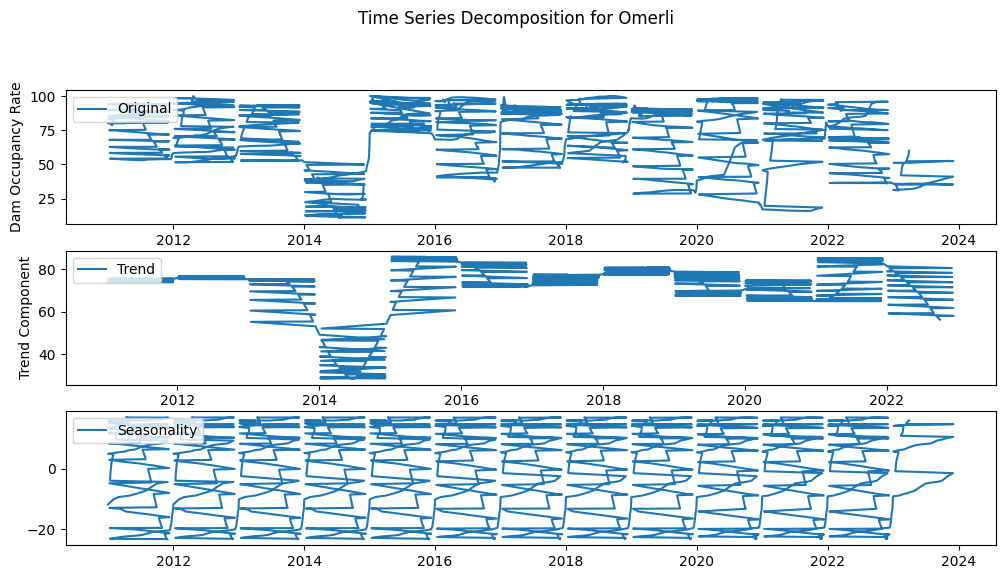

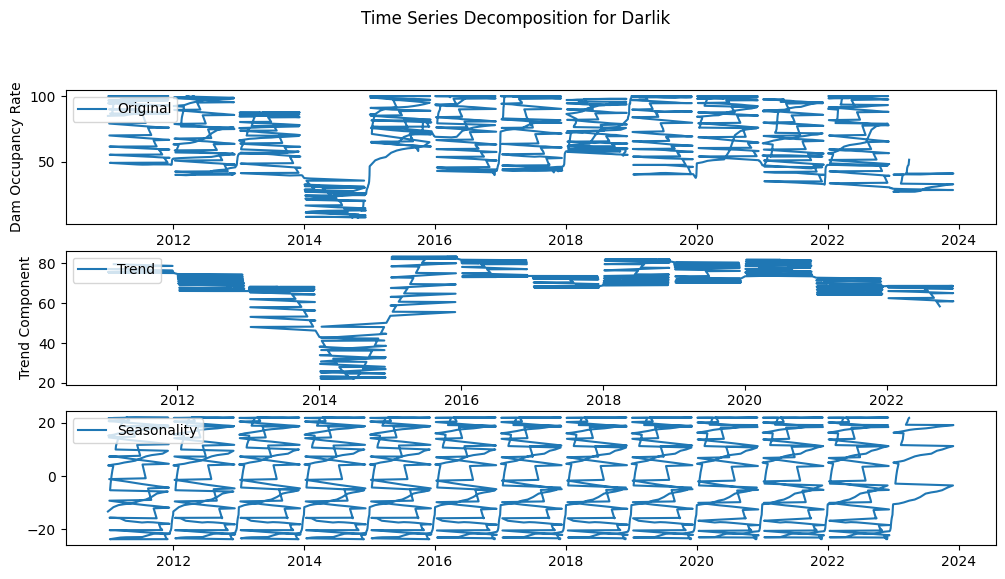

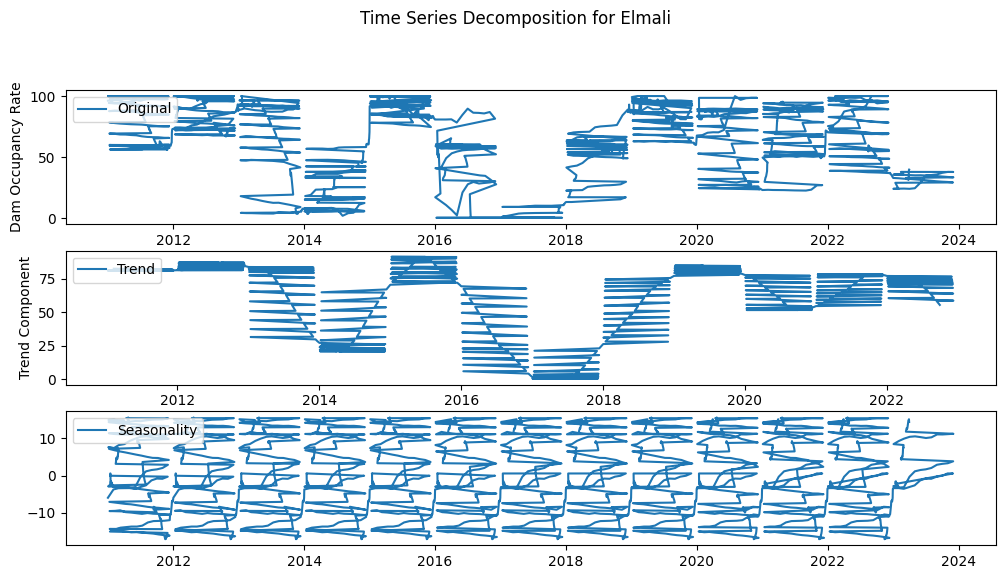

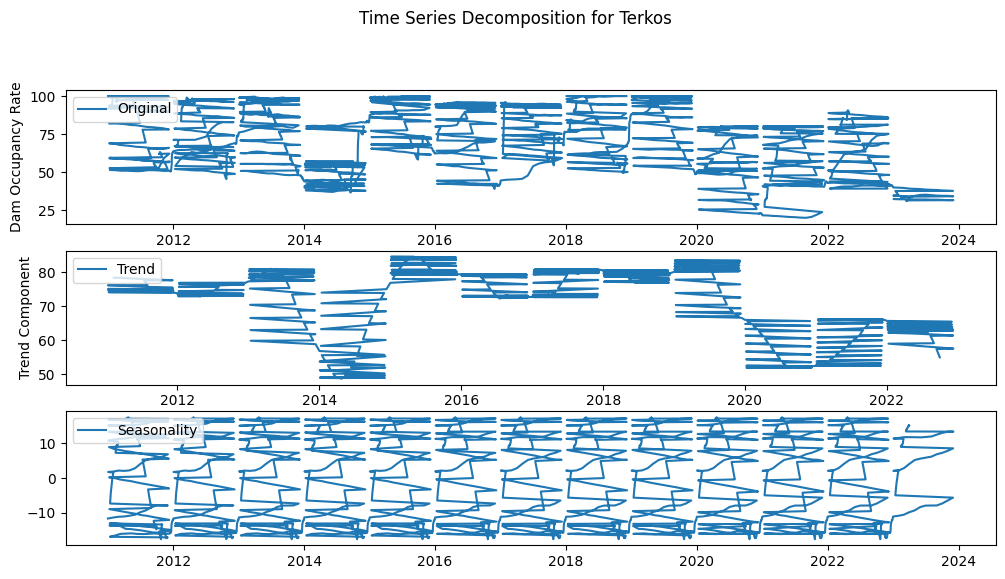

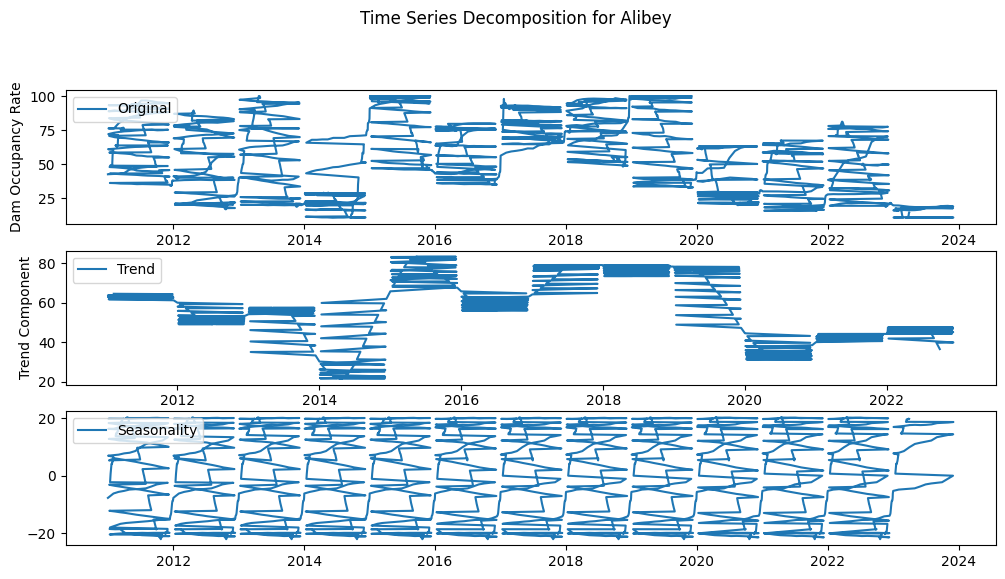

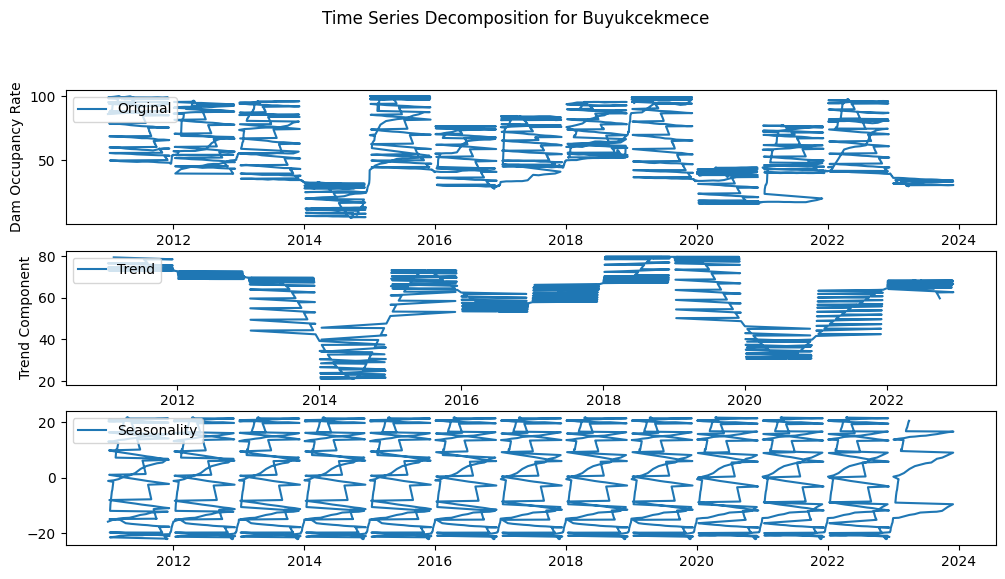

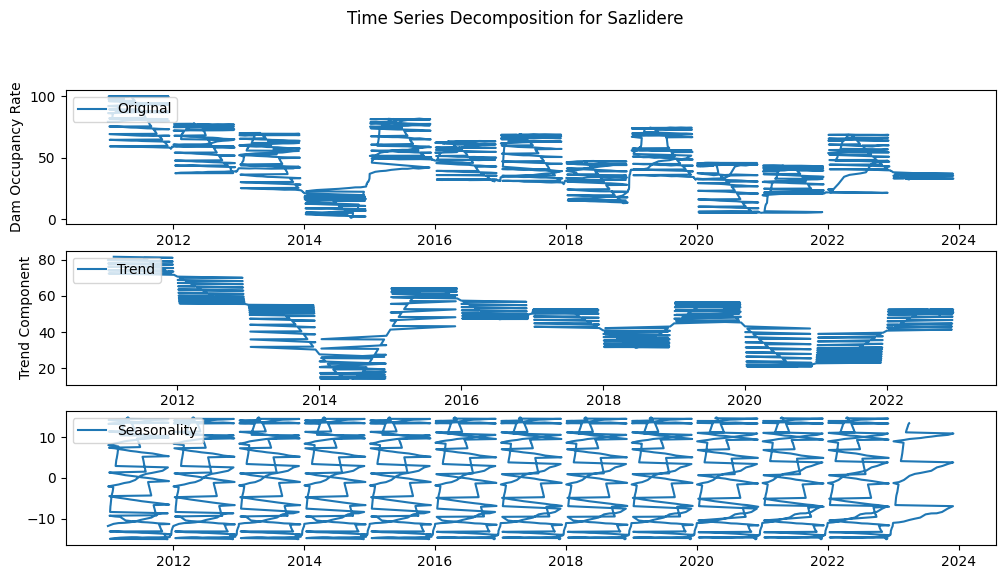

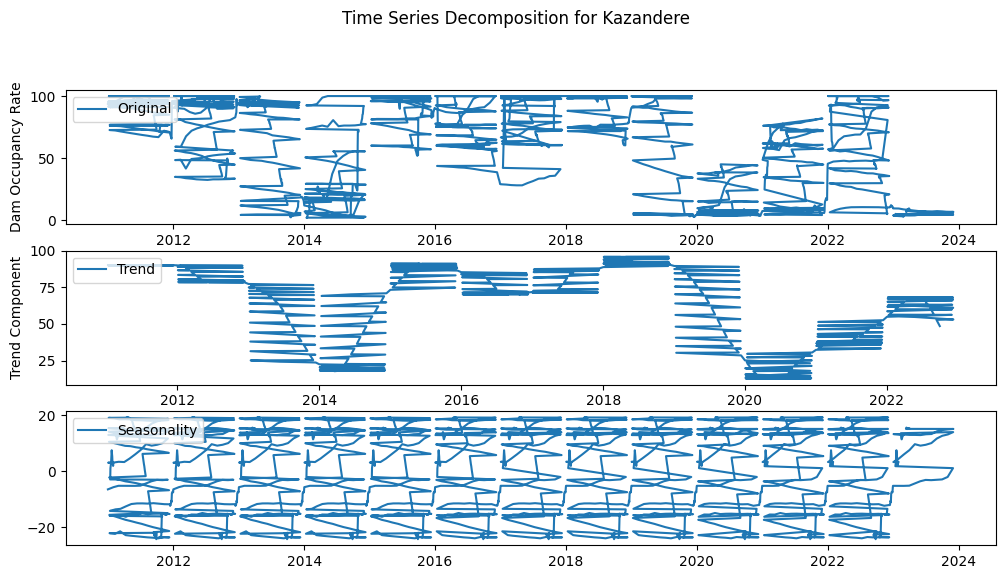

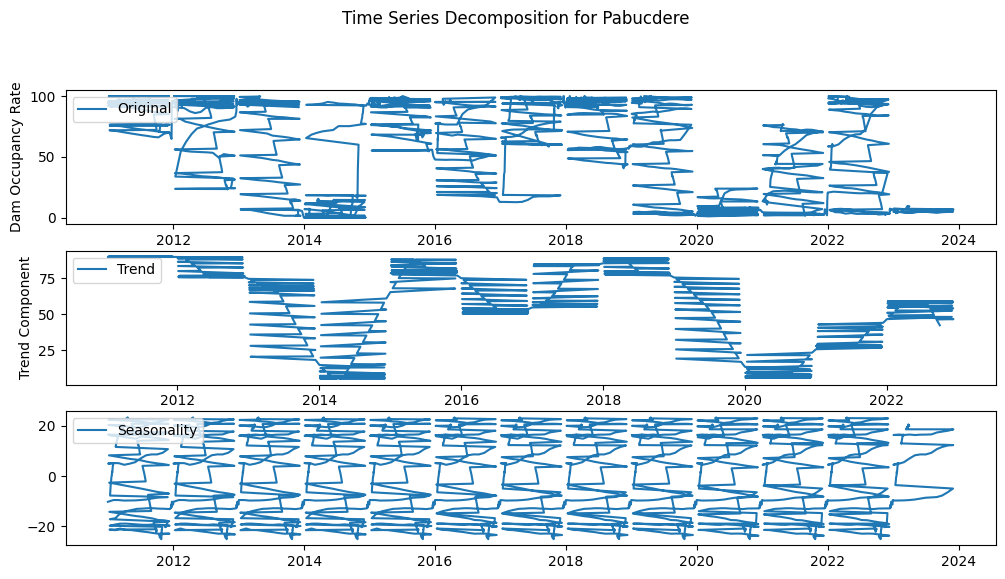

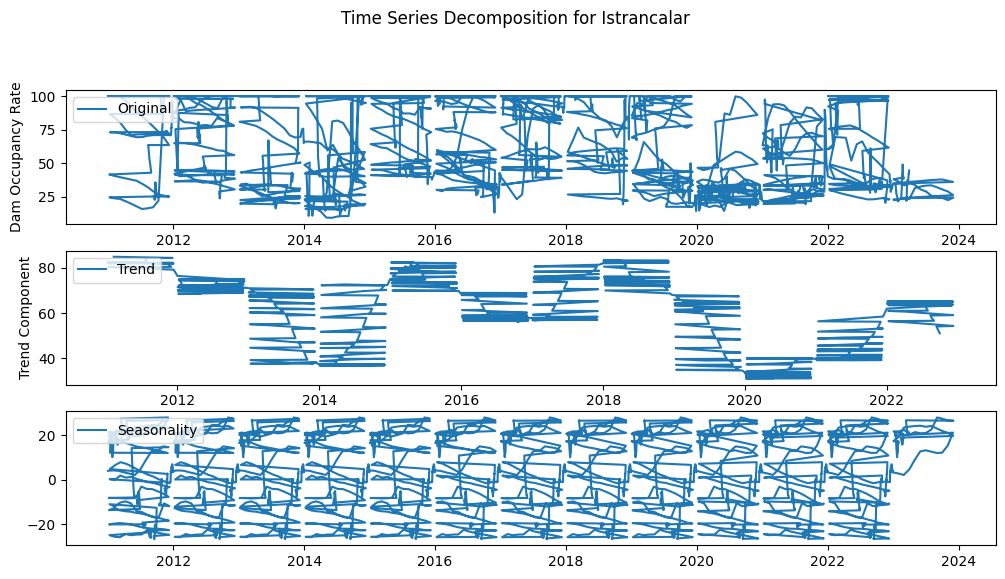

In [14]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Assuming your dataset is in a pandas DataFrame called 'df'
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

dams = ['Omerli', 'Darlik', 'Elmali', 'Terkos', 'Alibey', 'Buyukcekmece', 'Sazlidere', 'Kazandere', 'Pabucdere', 'Istrancalar']

for dam in dams:
    # Decompose the time series
    decomposition = seasonal_decompose(df[dam], model='additive', period=365)

    # Plot the decomposition components
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Time Series Decomposition for {dam}')
    
    plt.subplot(411)
    plt.plot(df[dam], label='Original')
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Dam Occupancy Rate')
    
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Trend Component')

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonality')
    plt.legend(loc='upper left')
    plt.xlabel


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller


In [24]:
def adf_test(series, column_name):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic for {column_name}: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'{key}: {value}')


In [26]:
# Replace the column names with those corresponding to the dam occupancy rates in your dataset
dam_columns = ['Omerli', 'Darlik', 'Elmali', 'Terkos', 'Alibey', 'Buyukcekmece', 'Sazlidere', 'Kazandere', 'Pabucdere', 'Istrancalar']

for column in dam_columns:
    print(f'ADF Test for {column}:')
    adf_test(df[column], column)
    print('\n')


ADF Test for Omerli:
ADF Statistic for Omerli: -4.25633835032635
p-value: 0.0005282393674289249
1%: -3.43215622115055
5%: -2.862338087688428
10%: -2.5671948344809046


ADF Test for Darlik:
ADF Statistic for Darlik: -4.705099771700045
p-value: 8.231593040690259e-05
1%: -3.43215622115055
5%: -2.862338087688428
10%: -2.5671948344809046


ADF Test for Elmali:
ADF Statistic for Elmali: -2.1861489418984945
p-value: 0.21131094396903088
1%: -3.4321532327220154
5%: -2.862336767636517
10%: -2.56719413172842


ADF Test for Terkos:
ADF Statistic for Terkos: -4.024022875366858
p-value: 0.00128981467177503
1%: -3.43215622115055
5%: -2.862338087688428
10%: -2.5671948344809046


ADF Test for Alibey:
ADF Statistic for Alibey: -4.114956953495829
p-value: 0.0009148351882677766
1%: -3.4321567201852456
5%: -2.862338308122449
10%: -2.5671949518327932


ADF Test for Buyukcekmece:
ADF Statistic for Buyukcekmece: -3.7348667969628933
p-value: 0.003648610121285528
1%: -3.4321522387754775
5%: -2.862336328589075
1

In [15]:
# Replace 'df' with the name of your dataframe, if different
monthly_df = df.resample('M').mean()


In [17]:
# to excel monthly_df
monthly_df.to_excel('monthly_df.xlsx', index=False)

In [29]:
def decompose_time_series(series, column_name):
    decomposition = seasonal_decompose(series, model='additive')
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Time Series Decomposition for {column_name}', fontsize=16)
    
    plt.subplot(411)
    plt.plot(series, label='Original')
    plt.legend(loc='upper left')
    
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='upper left')
    
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


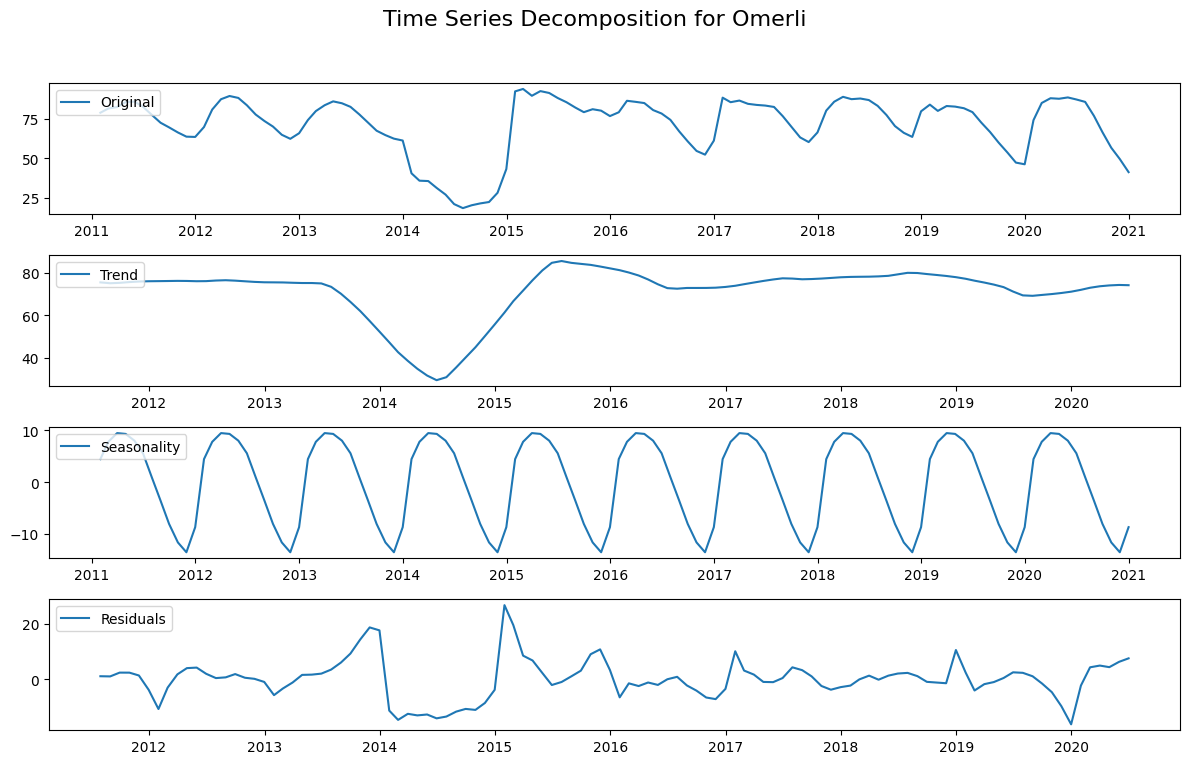

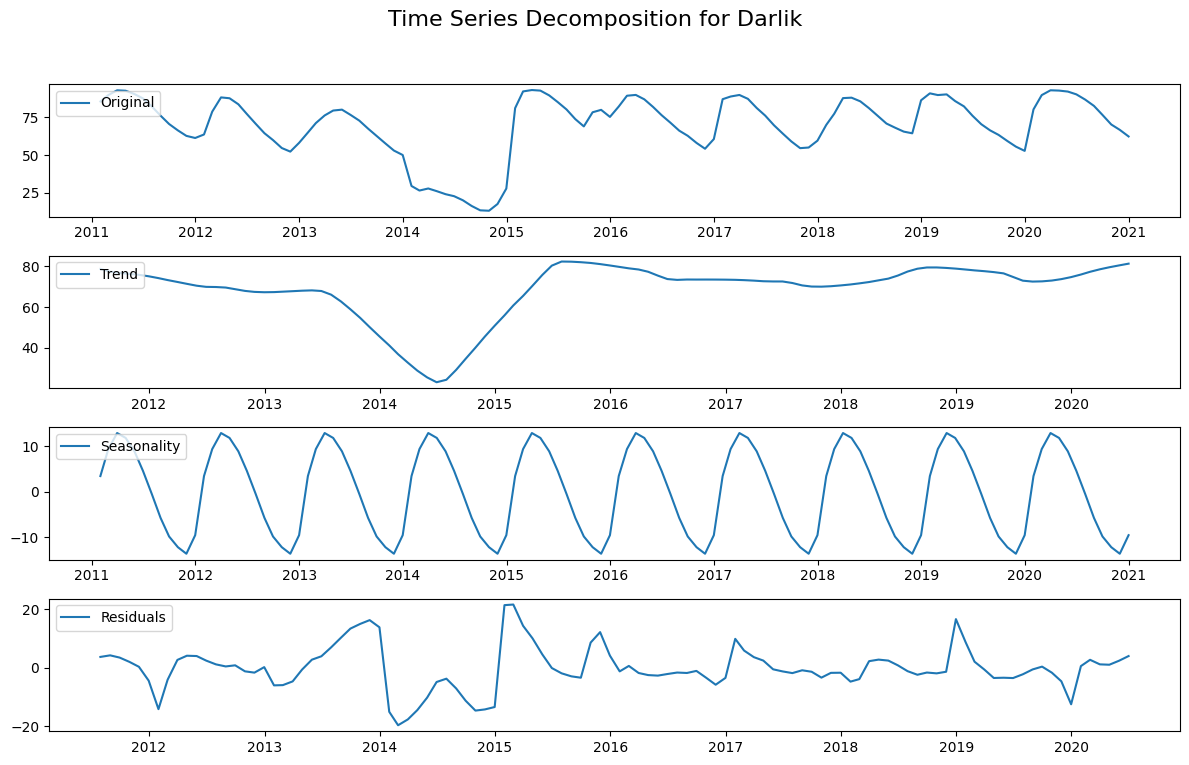

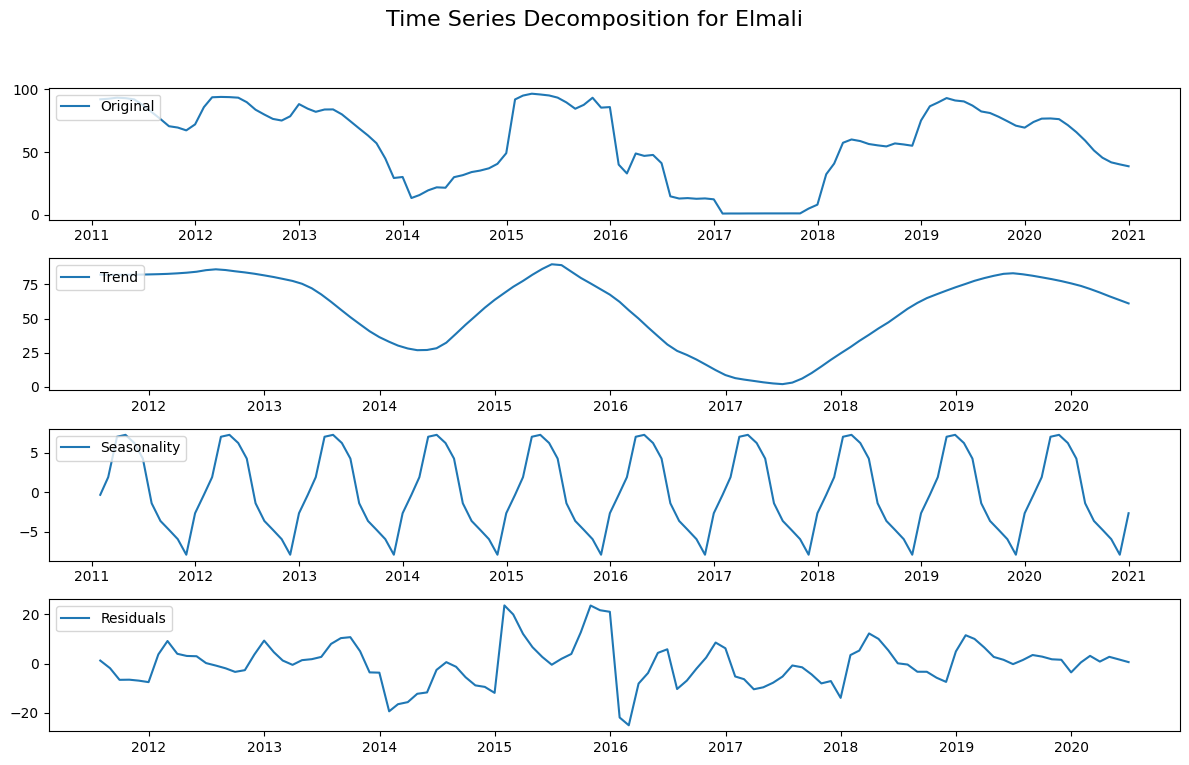

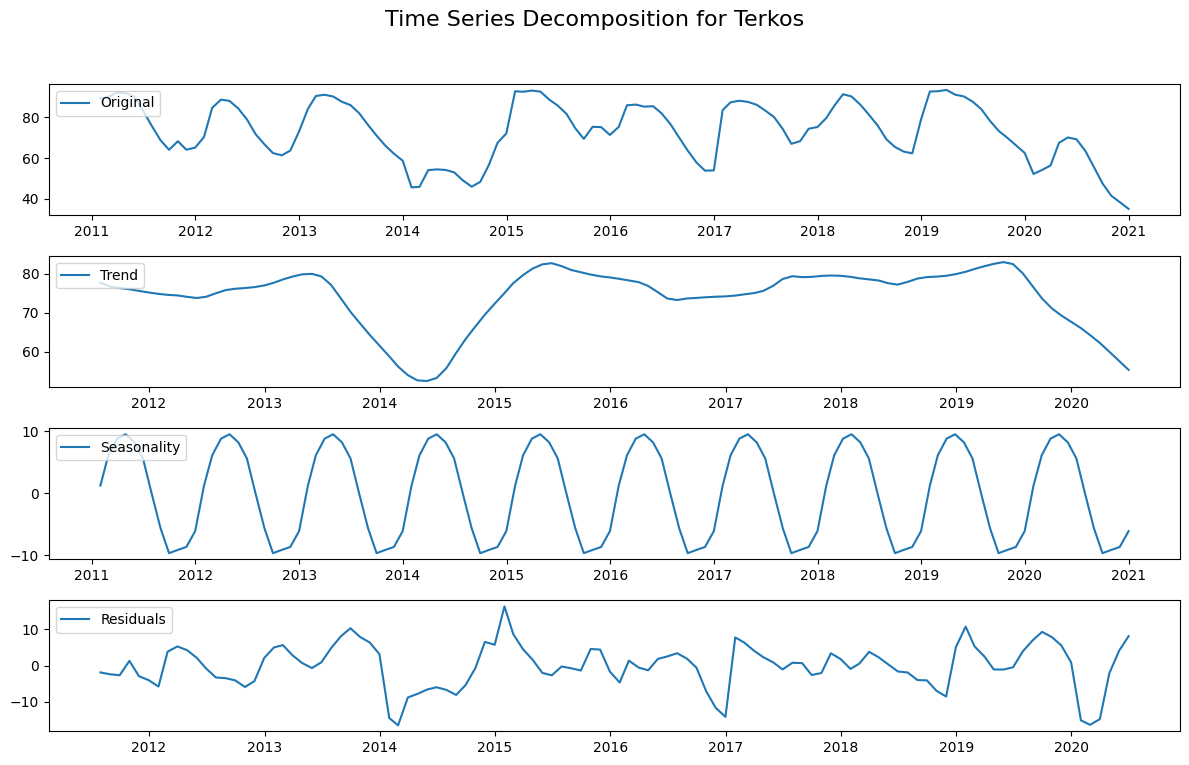

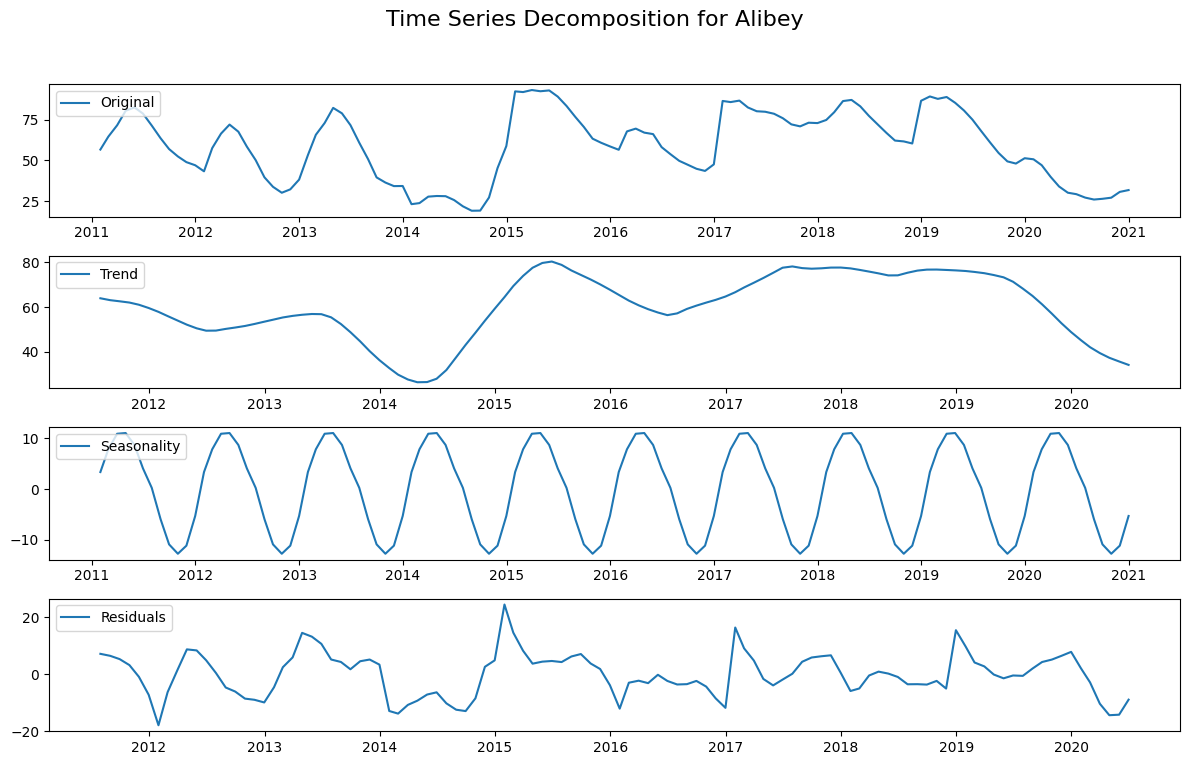

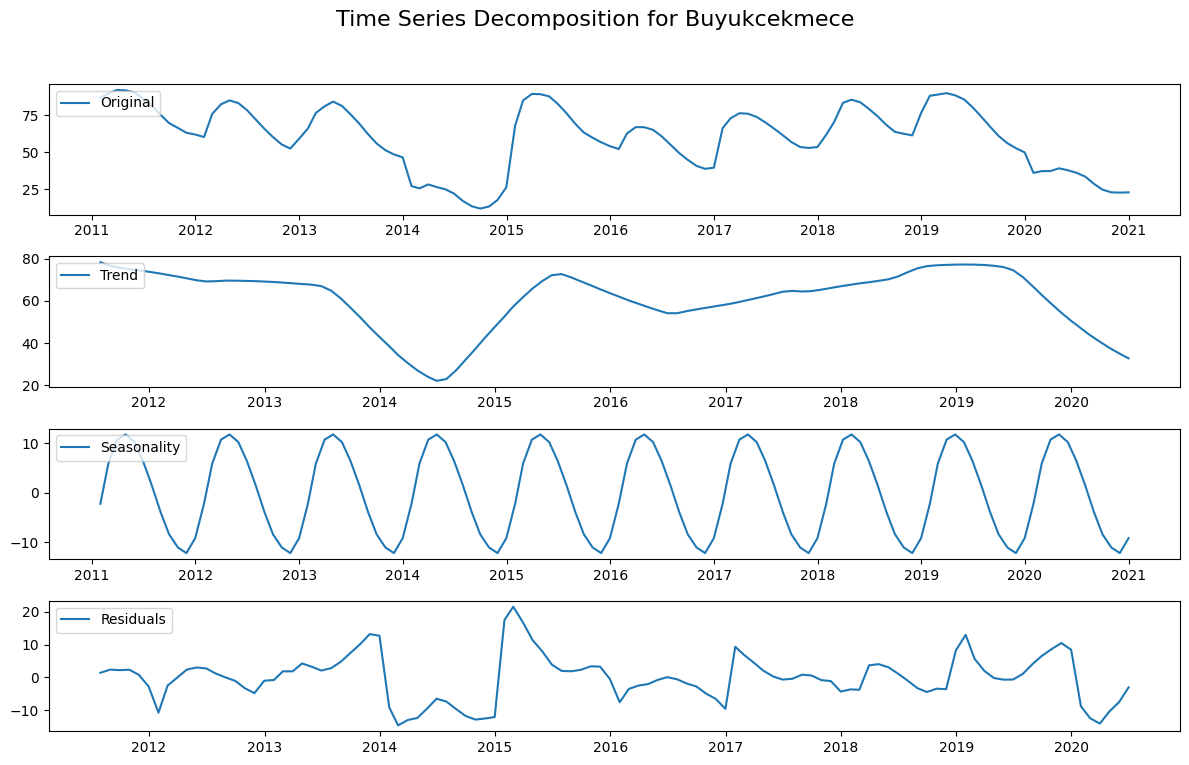

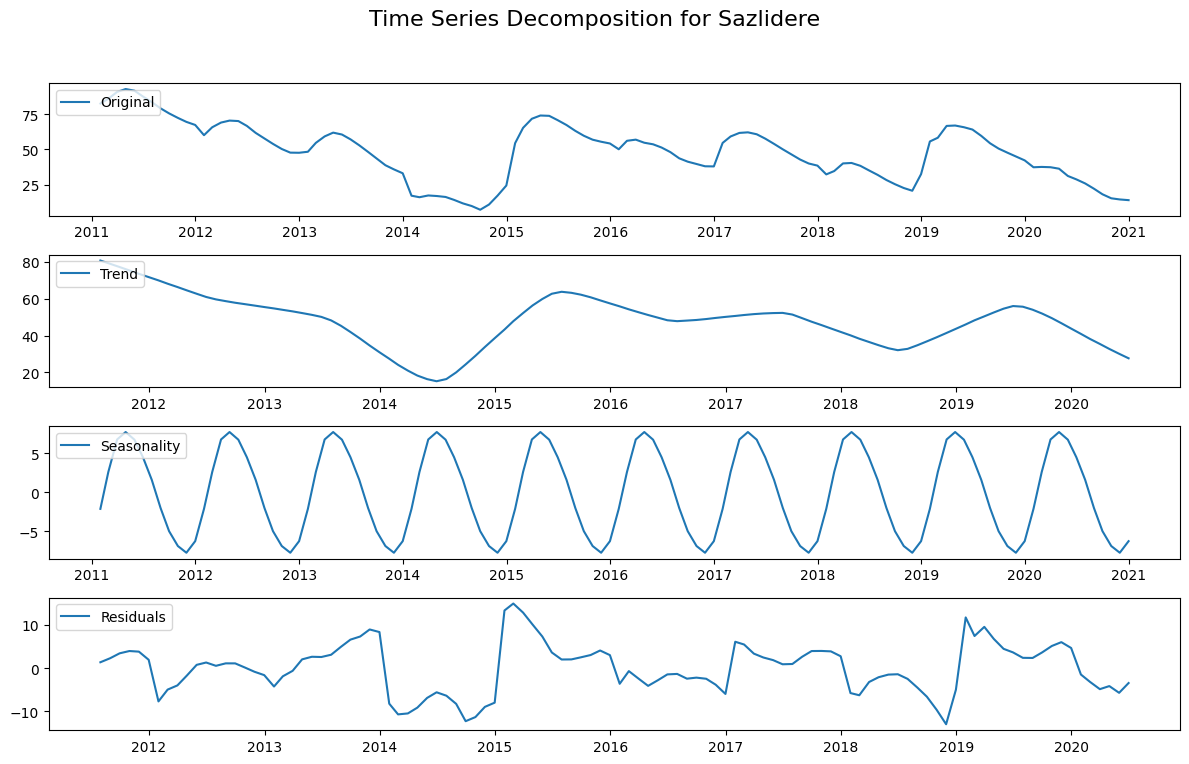

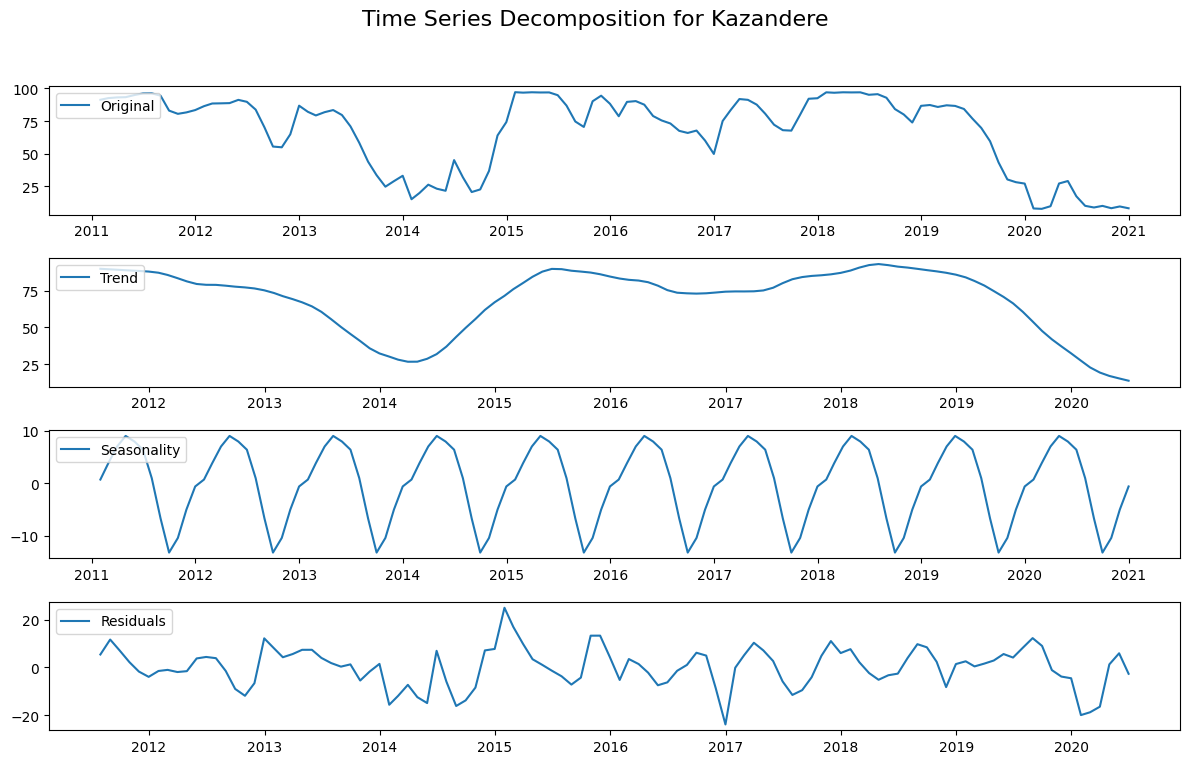

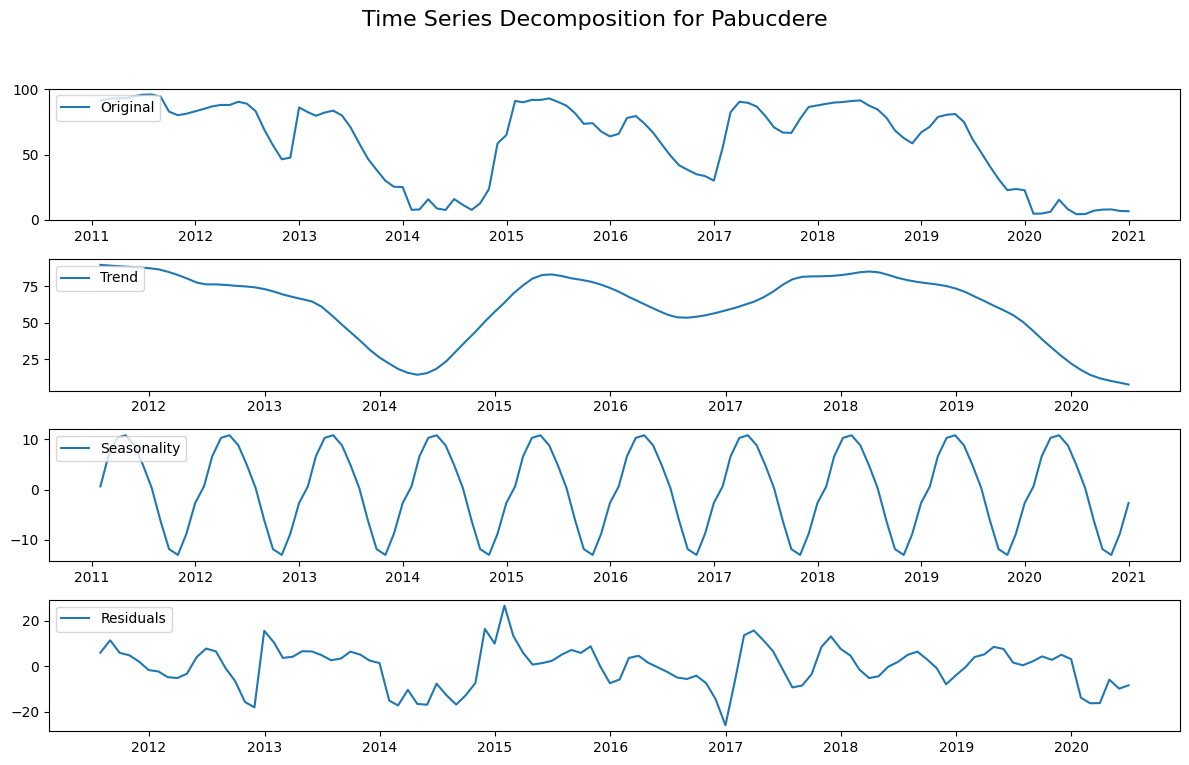

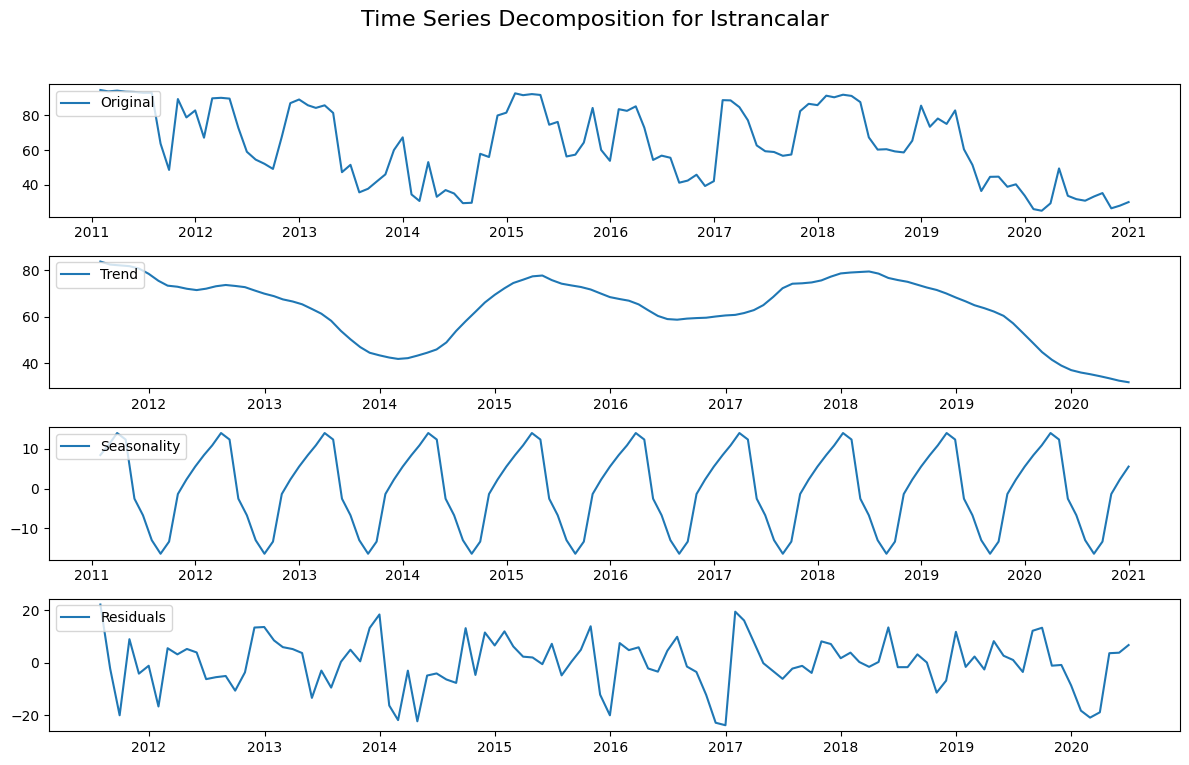

In [30]:
# Replace the column names with those corresponding to the dam occupancy rates in your dataset
dam_columns = ['Omerli', 'Darlik', 'Elmali', 'Terkos', 'Alibey', 'Buyukcekmece', 'Sazlidere', 'Kazandere', 'Pabucdere', 'Istrancalar']

for column in dam_columns:
    decompose_time_series(monthly_df[column], column)


In [31]:
def adf_test(series, column_name):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic for {column_name}: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'{key}: {value}')


In [33]:
# Replace the column names with those corresponding to the dam occupancy rates in your dataset
dam_columns = ['Omerli', 'Darlik', 'Elmali', 'Terkos', 'Alibey', 'Buyukcekmece', 'Sazlidere', 'Kazandere', 'Pabucdere', 'Istrancalar']

for column in dam_columns:
    print(f'ADF Test for {column}:')
    adf_test(monthly_df[column].dropna(), column)  # Drop missing values before applying the ADF test
    print('\n')



ADF Test for Omerli:
ADF Statistic for Omerli: -3.76601605553244
p-value: 0.003274793896789402
1%: -3.4870216863700767
5%: -2.8863625166643136
10%: -2.580009026141913


ADF Test for Darlik:
ADF Statistic for Darlik: -3.9171397853904026
p-value: 0.0019122668081498707
1%: -3.4870216863700767
5%: -2.8863625166643136
10%: -2.580009026141913


ADF Test for Elmali:
ADF Statistic for Elmali: -3.0731956411143204
p-value: 0.02860147923373014
1%: -3.4936021509366793
5%: -2.8892174239808703
10%: -2.58153320754717


ADF Test for Terkos:
ADF Statistic for Terkos: -3.988260650897702
p-value: 0.001473244887267583
1%: -3.4870216863700767
5%: -2.8863625166643136
10%: -2.580009026141913


ADF Test for Alibey:
ADF Statistic for Alibey: -3.9408418842964976
p-value: 0.0017540090228114038
1%: -3.487517288664615
5%: -2.8865777180380032
10%: -2.5801239192052012


ADF Test for Buyukcekmece:
ADF Statistic for Buyukcekmece: -3.556134414048649
p-value: 0.00665719129126413
1%: -3.4870216863700767
5%: -2.8863625166

In [34]:
def make_stationary(series, column_name, max_diff_order=2):
    for i in range(1, max_diff_order + 1):
        diff_series = series.diff(periods=i).dropna()
        adf_result = adfuller(diff_series, autolag='AIC')
        p_value = adf_result[1]

        if p_value < 0.05:
            print(f'Successfully made {column_name} stationary with differencing order {i}')
            return diff_series

    print(f'Unable to make {column_name} stationary with differencing')
    return None


In [35]:
# Replace the column names with those corresponding to the dam occupancy rates in your dataset
dam_columns = ['Omerli', 'Darlik', 'Elmali', 'Terkos', 'Alibey', 'Buyukcekmece', 'Sazlidere', 'Kazandere', 'Pabucdere', 'Istrancalar']

stationary_series = {}

for column in dam_columns:
    print(f'Attempting to make {column} stationary:')
    stationary = make_stationary(monthly_df[column], column)
    if stationary is not None:
        stationary_series[column] = stationary
    print('\n')


Attempting to make Omerli stationary:
Successfully made Omerli stationary with differencing order 1


Attempting to make Darlik stationary:
Successfully made Darlik stationary with differencing order 1


Attempting to make Elmali stationary:
Successfully made Elmali stationary with differencing order 1


Attempting to make Terkos stationary:
Successfully made Terkos stationary with differencing order 1


Attempting to make Alibey stationary:
Successfully made Alibey stationary with differencing order 1


Attempting to make Buyukcekmece stationary:
Successfully made Buyukcekmece stationary with differencing order 1


Attempting to make Sazlidere stationary:
Successfully made Sazlidere stationary with differencing order 1


Attempting to make Kazandere stationary:
Successfully made Kazandere stationary with differencing order 1


Attempting to make Pabucdere stationary:
Successfully made Pabucdere stationary with differencing order 1


Attempting to make Istrancalar stationary:
Successfu

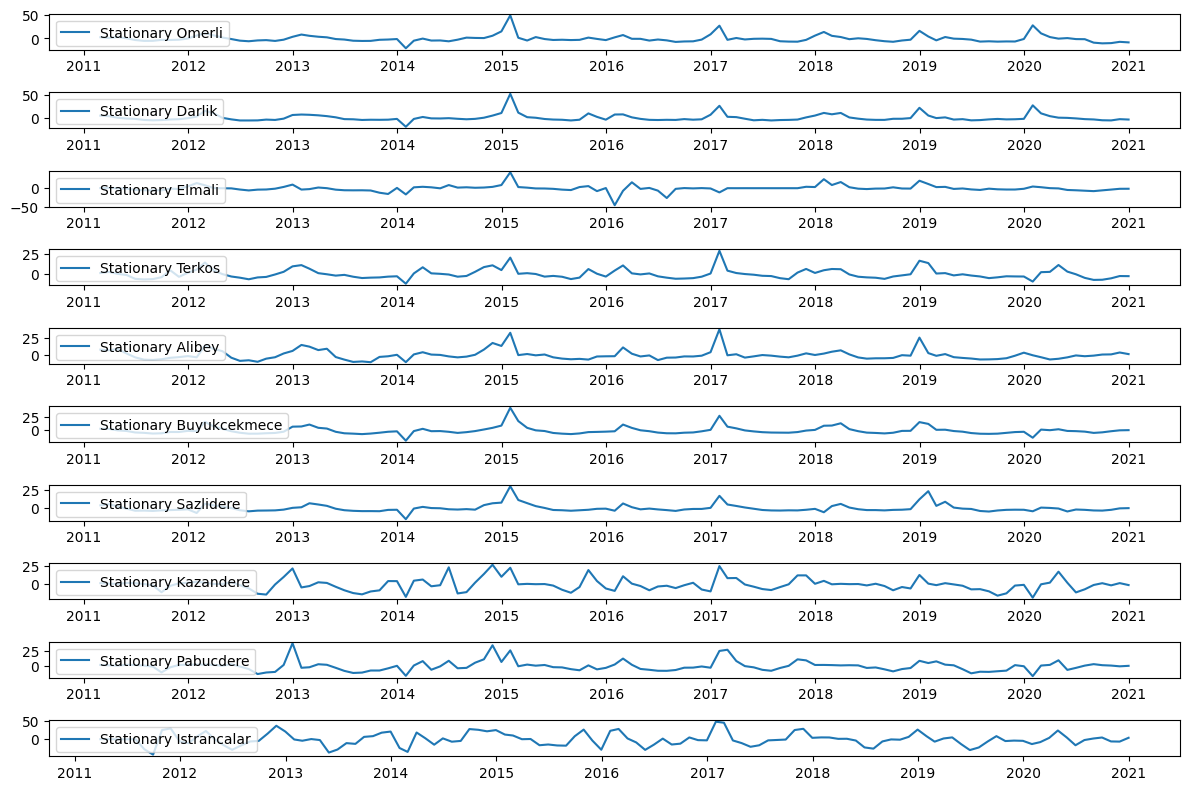

In [36]:
plt.figure(figsize=(12, 8))

for i, (column, series) in enumerate(stationary_series.items()):
    plt.subplot(len(stationary_series), 1, i + 1)
    plt.plot(series, label=f'Stationary {column}')
    plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from math import sqrt


In [19]:
monthly_data = monthly_df

In [20]:
# Choose a dam to analyze, e.g., 'Omerli'
dam = 'Omerli'

# Split the data into training and validation sets (80% for training and 20% for validation)
train = monthly_data[dam][:int(0.8 * len(monthly_data))]
valid = monthly_data[dam][int(0.8 * len(monthly_data)):]


In [21]:
# Use auto_arima to find the optimal parameters for the ARIMA model
arima_model = auto_arima(train, seasonal=False, trace=True, suppress_warnings=True)

# Print the model's summary
print(arima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=856.015, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1420.248, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1263.624, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=854.195, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=853.961, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=854.030, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=853.242, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=853.913, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=834.963, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=870.670, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=836.890, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=836.844, Time=0

In [22]:
# Make predictions for the validation dataset
predictions = arima_model.predict(n_periods=len(valid))

# Calculate the RMSE (Root Mean Squared Error) between the predictions and actual occupancy levels
rmse = sqrt(mean_squared_error(valid, predictions))

print("RMSE:", rmse)


RMSE: 20.05585073331734


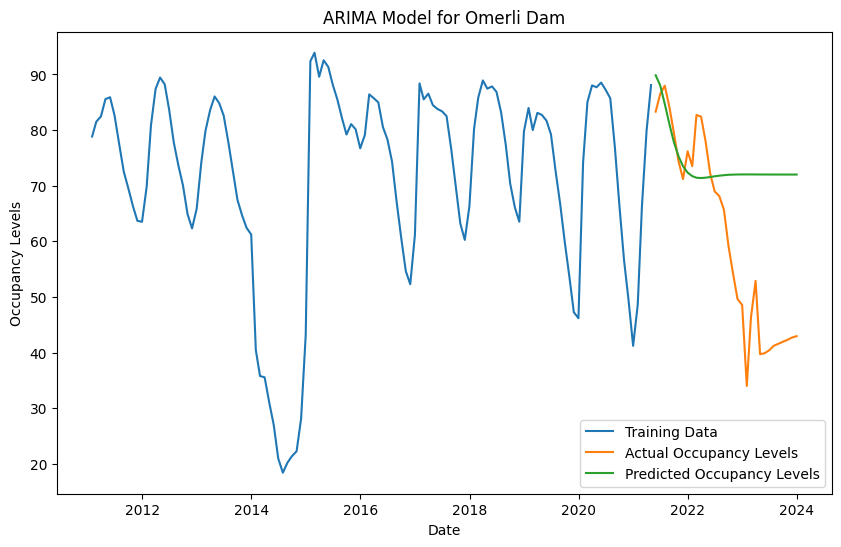

In [23]:
# Create a plot to visualize the model's performance
plt.figure(figsize=(10, 6))
plt.plot(train, label="Training Data")
plt.plot(valid, label="Actual Occupancy Levels")
plt.plot(valid.index, predictions, label="Predicted Occupancy Levels")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Occupancy Levels")
plt.title(f"ARIMA Model for {dam} Dam")
plt.show()


In [31]:
# Choose a dam to analyze, e.g., 'Omerli'
dam = 'Omerli'

# Split the data into training and validation sets (80% for training and 20% for validation)
train = monthly_data[dam][:int(0.8 * len(monthly_data))]
valid = monthly_data[dam][int(0.8 * len(monthly_data)):]


In [38]:

# For this example, we assume a seasonal period of 12 months
sarima_model = auto_arima(train, seasonal=True, m=6, trace=True, suppress_warnings=True)

# Print the model's summary
print(sarima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[6] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=1073.096, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=865.639, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=950.659, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=1420.248, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[6] intercept   : AIC=870.670, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[6] intercept   : AIC=866.791, Time=0.30 sec
 ARIMA(1,0,0)(1,0,1)[6] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,0,0)(0,0,1)[6] intercept   : AIC=866.682, Time=0.13 sec
 ARIMA(1,0,0)(2,0,1)[6] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(1,0,0)[6] intercept   : AIC=1075.024, Time=0.16 sec
 ARIMA(2,0,0)(1,0,0)[6] intercept   : AIC=836.958, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[6] intercept   : AIC=834.963, Time=0.08 sec
 ARIMA(2,0,0)(0,0,1)[6] intercept   : AIC=836.958, Time=0.42 sec
 ARIMA(2,0,0)(1,0,1)[6] intercept   : AIC=838.891, Time=

In [39]:
# Make predictions for the validation dataset
predictions = sarima_model.predict(n_periods=len(valid))

# Calculate the RMSE (Root Mean Squared Error) between the predictions and actual occupancy levels
rmse = sqrt(mean_squared_error(valid, predictions))

print("RMSE:", rmse)


RMSE: 20.05585073331734


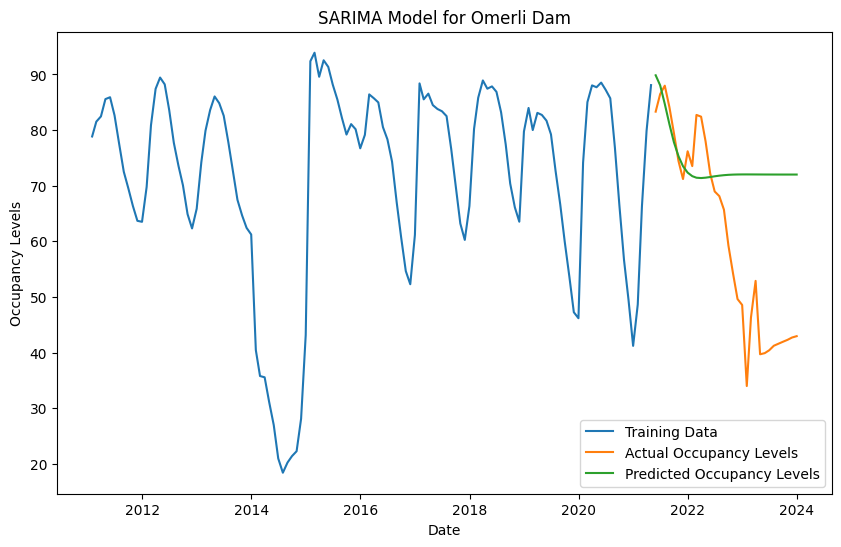

In [40]:
# Create a plot to visualize the model's performance
plt.figure(figsize=(10, 6))
plt.plot(train, label="Training Data")
plt.plot(valid, label="Actual Occupancy Levels")
plt.plot(valid.index, predictions, label="Predicted Occupancy Levels")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Occupancy Levels")
plt.title(f"SARIMA Model for {dam} Dam")
plt.show()


In [94]:
#  open   tsv  file
df = pd.read_csv('Istanbul Dams Daily Occupancy Rates (%).tsv', sep='\t')
df.head()

_id                Tarih  Omerli  Darlik  Elmali  Terkos  Alibey  \
0    1  2011-01-01T00:00:00  80,07%  84,86%  96,25%  91,87%  42,48%   
1    2  2011-02-01T00:00:00  80,07%  85,02%  96,67%  91,68%  42,71%   
2    3  2011-03-01T00:00:00  80,07%  85,07%  96,88%  91,68%  42,79%   
3    4  2011-04-01T00:00:00  80,07%  85,18%  95,00%  92,44%  43,34%   
4    5  2011-05-01T00:00:00  80,61%  85,98%  95,21%  92,63%  45,81%   

  Buyukcekmece Sazlidere Kazandere Pabucdere Istrancalar  
0       85,99%    79,10%    93,90%    94,19%      99,99%  
1       86,17%    79,21%    92,80%    93,11%      99,99%  
2       86,55%    79,31%    91,39%    91,71%      99,99%  
3       86,74%    79,96%    90,65%    90,99%      99,99%  
4       87,30%    80,37%    90,93%    91,26%      99,99%

In [95]:
# Convert all 'occupancy rate' columns to float
dams = ['Omerli', 'Darlik', 'Elmali', 'Terkos', 'Alibey', 'Buyukcekmece', 'Sazlidere', 'Kazandere', 'Pabucdere', 'Istrancalar']
for dam in dams:
    df[dam] = df[dam].str.replace('%', '')
dams = ['Omerli', 'Darlik', 'Elmali', 'Terkos', 'Alibey', 'Buyukcekmece', 'Sazlidere', 'Kazandere', 'Pabucdere', 'Istrancalar']
for dam in dams:
    df[dam] = df[dam].str.replace(',', '.').astype(float) 

In [96]:
# Tarih column  name  change  to  date
df.rename(columns={'Tarih': 'Date'}, inplace=True)

In [97]:
data = df

In [98]:
# Convert 'Date' column to a datetime data type
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' column as the index
data.set_index('Date', inplace=True)

# Resample the dataset to monthly intervals
monthly_data = data.resample('M').mean()

In [100]:
def create_lagged_features(data, num_lags):
    df = data.copy()
    for i in range(1, num_lags + 1):
        df[f'lag_{i}'] = df['Omerli'].shift(i)
    return df

num_lags = 12
lagged_data = create_lagged_features(monthly_data, num_lags)
lagged_data.dropna(inplace=True)


In [50]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split

In [51]:
# Choose a dam to analyze, e.g., 'Omerli'
dam = 'Omerli'

X = lagged_data.drop(dam, axis=1).values
y = lagged_data[dam].values

# Split the dataset into training and testing sets (80% for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [115]:
X

Omerli  Darlik  Elmali  Terkos  Alibey  Buyukcekmece  Sazlidere  \
Date                                                                          
2011-01-01   80.07   84.86   96.25   91.87   42.48         85.99      79.10   
2011-02-01   80.07   85.02   96.67   91.68   42.71         86.17      79.21   
2011-03-01   80.07   85.07   96.88   91.68   42.79         86.55      79.31   
2011-04-01   80.07   85.18   95.00   92.44   43.34         86.74      79.96   
2011-05-01   80.61   85.98   95.21   92.63   45.81         87.30      80.37   
...            ...     ...     ...     ...     ...           ...        ...   
2023-03-27   56.24   47.31   31.44   31.83   11.65         29.76      32.41   
2023-03-28   56.72   47.49   32.71   31.98   11.96         30.10      32.53   
2023-03-29   58.15   49.11   37.42   32.57   13.10         30.77      32.77   
2023-03-30   59.47   50.87   39.64   32.72   14.09         30.94      32.70   
2023-03-31   60.10   51.46   39.90   32.57   14.28         30.61      32.58   

            Kazandere  Pabucdere  Istrancalar  
Date                                           
2011-01-01      93.90      94.19        99.99  
2011-02-01      92.80      93.11        99.99  
2011-03-01      91.39      91.71        99.99  
2011-04-01      90.65      90.99        99.99  
2011-05-01      90.93      91.26        99.99  
...               ...        ...          ...  
2023-03-27       8.59       9.08        39.61  
2023-03-28       8.54       8.95        41.59  
2023-03-29       9.20       9.59        42.87  
2023-03-30       9.39       9.68        42.51  
2023-03-31       9.20       9.52        44.68  

[4473 rows x 10 columns]

In [116]:
y

Date
2011-01-01    80.07
2011-02-01    80.07
2011-03-01    80.07
2011-04-01    80.07
2011-05-01    80.61
              ...  
2023-03-27    56.24
2023-03-28    56.72
2023-03-29    58.15
2023-03-30    59.47
2023-03-31    60.10
Name: Omerli, Length: 4473, dtype: float64

In [52]:
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [53]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Calculate the RMSE (Root Mean Squared Error) between the predictions and actual values
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)


RMSE: 5.5729872308054


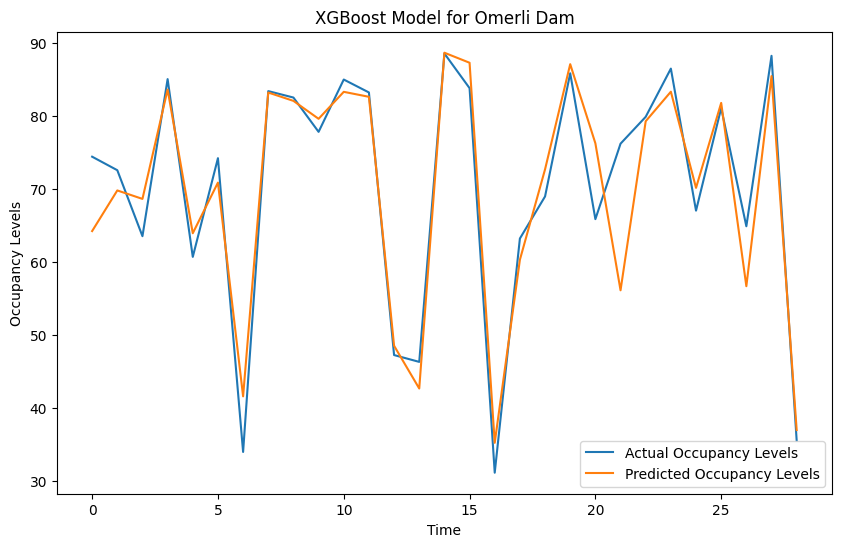

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Actual Occupancy Levels")
plt.plot(y_pred, label="Predicted Occupancy Levels")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Occupancy Levels")
plt.title(f"XGBoost Model for {dam} Dam")
plt.show()
